Lab 7, Aleksandr Berezutskii, group 4, Skoltech 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The objective of this laboratory work is to develop algorithms to improve Kalman filter estimates, that is of prime importance for many practical control and forecasting problems. This will bring about a deeper understanding of main difficulties of practical Kalman filter
implementation and skills to overcome these difficulties to get optimal assimilation output.

Smoothing procedure is performed in backward in time and is applied to forward Kalman filter
estimates. Smoothing takes into account both current and future measurements and therefore
provides improved estimation compared to Kalman filter.

Let us build a trajectory of a moving object that is disturbed by normally distributed unbiased random acceleration $a_i$ with variance $\sigma_a = 0.2$. All other conditions are the same as in Lab 5.

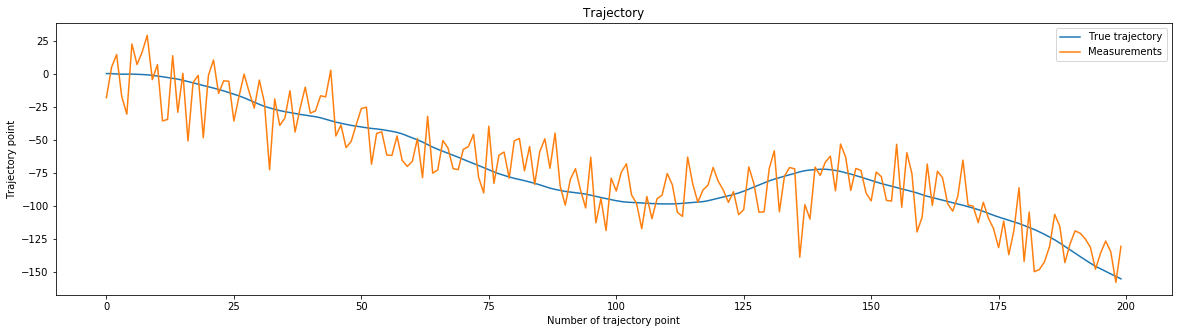

In [2]:
#noise of acceleration
sigmaacc = 0.2
acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)

#steps, speed and time interval
x = np.zeros(len(acc))
x[0] = 5

V = np.zeros(len(acc))
V[0] = 1

T = 1

#trajectory
for i in range(len(acc)):
    x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
    V[i] = V[i-1] + acc[i-1]*T
    
#noise of measurements
sigmaeta = 20
eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)

#measurements of the steps
z = np.zeros(len(acc))
for i in range(len(acc)):
    z[i] = x[i] + eta[i]
    
plt.figure(figsize=(20,5))
plt.plot(x, '-')
plt.plot(z, '-')
plt.title('Trajectory')
plt.ylabel('Trajectory point')
plt.xlabel('Number of trajectory point')
plt.legend(['True trajectory', 'Measurements'], loc = 'best')
plt.show()

Here we develop forward Kalman filter algorithm.

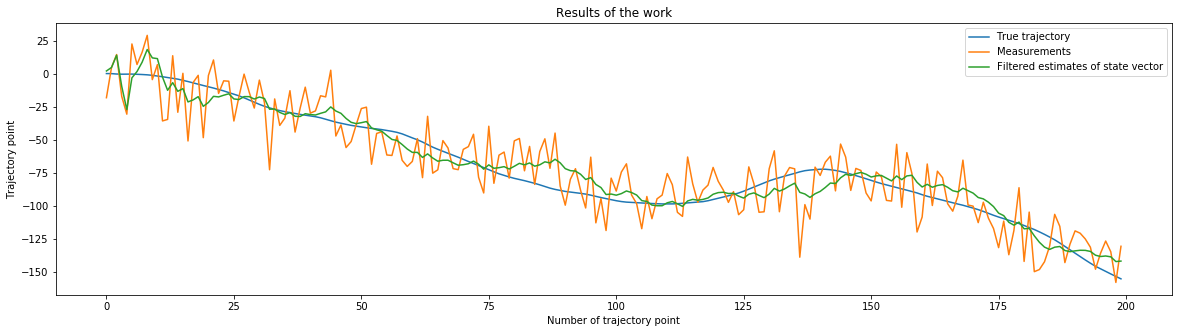

In [3]:
#making state vectors
X = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    X[i,0] = x[i]
    X[i,1] = V[i]
    X[i] = np.matrix([[x[i]], [V[i]]])
    
#making a transition matrix
PHI = np.matrix([[1, T], [0, 1]])

#making an input matrix
G = np.matrix([[T**2/2],[T]])

#making an observation matrix
H = np.matrix([1, 0])

#initial filtered estimate
X[0] = np.matrix([[2],[0]])

#initial filtration error covariance matrix P[i,i]
P = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    P[i] = np.matrix([[0, 0], [0, 0]])
P[0] = np.matrix([[10**4, 0], [0, 10**4]])

#prediction error covariance matrix P[i+1,i]
L = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    L[i] = np.matrix([[0, 0], [0, 0]])

#covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
Q = (sigmaacc**2) * (G @ G.T)

#covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
R = np.matrix([sigmaeta**2])
e = np.zeros(len(acc))
K = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    K[i] = np.matrix([[0], [0]])

#Let's start Kalman filter algorithm
for i in range(1, len(acc)):
    #Prediction
    X[i] = PHI @ X[i-1]
    #Prediction error covariance matrix
    P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    L[i] = P[i]
    #Filtration
    e[i] = (H @ P[i] @ H.T + R)**(-1)
    K[i] = e[i] * (P[i] @ H.T)
    X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
    #Filtration error covariance matrix
    P[i] = (np.identity(2) - K[i] @ H) @ P[i] 
    
plt.figure(figsize=(20,5))
plt.plot(x, '-')
plt.plot(z, '-')
plt.plot(X[:,0,0], '-')
plt.title('Results of the work')
plt.ylabel('Trajectory point')
plt.xlabel('Number of trajectory point')
plt.legend(['True trajectory', 'Measurements', 'Filtered estimates of state vector'], loc = 'best')
plt.show()

Now let's develop backward smoothing algorithm to get improved estimates of state vector $X_i$

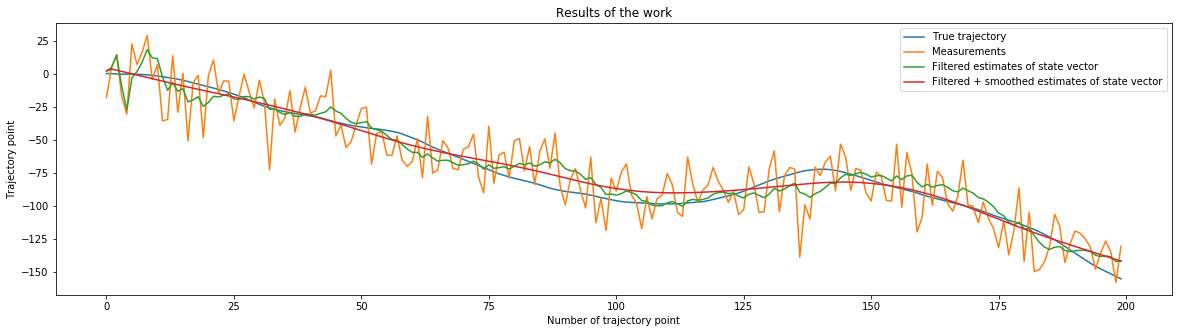

In [4]:
#initial coefficient matrices that we'll need in backward smoothing
A = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    A[i] = np.matrix([[1, 0], [0, 1]])
    
#making a new state vector, so that X will be affected only by Kalman, but X1 will be both Kalman filtered and backward smoothed
X1 = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    X1[i] = np.matrix([[X[i, 0, 0]], [X[i, 1, 0]]])

for i in range(len(acc)-2, 0, -1):
    A[i] = P[i] @ PHI.T @ np.linalg.inv(L[i+1])
    X1[i] = X1[i] + A[i] @ (X1[i+1] - PHI*X1[i])
    P[i] = P[i] + A[i] @ (P[i+1] - P[i]) @ A[i].T

plt.figure(figsize=(20,5))
plt.plot(x, '-')
plt.plot(z, '-')
plt.plot(X[:,0,0], '-')
plt.plot(X1[:,0,0], '-')
plt.title('Results of the work')
plt.ylabel('Trajectory point')
plt.xlabel('Number of trajectory point')
plt.legend(['True trajectory', 'Measurements', 'Filtered estimates of state vector', 'Filtered + smoothed estimates of state vector'], loc = 'best')
plt.show()

Let's make 500 runs of smoothing and compare coordinates' $x_i$ 
1. True estimation error ($x_i - z_i$)
2. Errors of Kalman filter ($x_i - x^{Kalman}_i$)
3. Errors of Kalman + backward moothing ($x_i - x^{Kalman + backward \ smoothing}_i$)

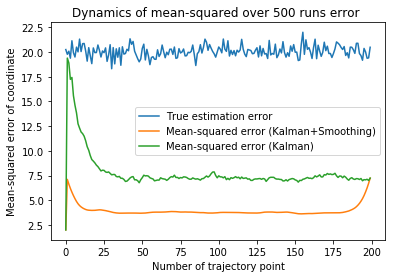

In [5]:
M=500
Errors = np.zeros((M, len(acc)))
Errors1 = np.zeros((M, len(acc)))
Errors2 = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
        
    #prediction error covariance matrix P[i+1,i]
    L = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        L[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**4, 0], [0, 10**4]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
        #Let's start Kalman filter algorithm
    for i in range(1, len(acc)):
        #Prediction
        X[i] = PHI @ X[i-1]
        #Prediction error covariance matrix
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
        L[i] = P[i]
        #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        #Filtration error covariance matrix
        P[i] = (np.identity(2) - K[i] @ H) @ P[i] 
    
        #initial coefficient matrices that we'll need in backward smoothing
    A = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        A[i] = np.matrix([[1, 0], [0, 1]])
    
        #making a new state vector, so that X will be affected only by Kalman, but X1 will be both Kalman filtered and backward smoothed
    X1 = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X1[i] = np.matrix([[X[i, 0, 0]], [X[i, 1, 0]]])

    for i in range(len(acc)-2, 0, -1):
        A[i] = P[i] @ PHI.T @ np.linalg.inv(L[i+1])
        X1[i] = X1[i] + A[i] @ (X1[i+1] - PHI*X1[i])
        P[i] = P[i] + A[i] @ (P[i+1] - P[i]) @ A[i].T
    
    
    
    #Errors gathering
        for i in range(len(acc)):
            Errors[j, i] = (z[i] - x[i])**2
            Errors1[j, i] = (X1[i,0,0] - x[i])**2
            Errors2[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
Fin_Err_squared1 = np.zeros(len(acc))
Fin_Err_squared2 = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]
        Fin_Err_squared1[i] += (1/(M-1))*Errors1[j, i]
        Fin_Err_squared2[i] += (1/(M-1))*Errors2[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.plot(np.sqrt(Fin_Err_squared1), '-')
plt.plot(np.sqrt(Fin_Err_squared2), '-')
plt.title('Dynamics of mean-squared over 500 runs error ')
plt.ylabel('Mean-squared error of coordinate')
plt.xlabel('Number of trajectory point')
plt.legend(['True estimation error', 'Mean-squared error (Kalman+Smoothing)', 'Mean-squared error (Kalman)'], loc = 'best')
plt.show()

We can see that the error of Kalman+Smoothing becomes approximately twice less and also we can see that the smoothing starts from the end (backward in the name), so this tells us that we're right in our code

Let's make 500 runs of smoothing and compare velocities' $v_i$ errors of Kalman with errors of Kalman+Smoothing

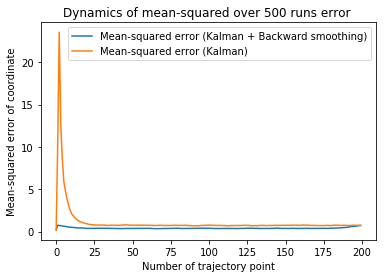

In [6]:
M=500
Errors = np.zeros((M, len(acc)))
Errors1 = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
        
    #prediction error covariance matrix P[i+1,i]
    L = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        L[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**4, 0], [0, 10**4]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
        #Let's start Kalman filter algorithm
    for i in range(1, len(acc)):
        #Prediction
        X[i] = PHI @ X[i-1]
        #Prediction error covariance matrix
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
        L[i] = P[i]
        #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        #Filtration error covariance matrix
        P[i] = (np.identity(2) - K[i] @ H) @ P[i] 
    
        #initial coefficient matrices that we'll need in backward smoothing
    A = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        A[i] = np.matrix([[1, 0], [0, 1]])
    
        #making a new state vector, so that X will be affected only by Kalman, but X1 will be both Kalman filtered and backward smoothed
    X1 = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X1[i] = np.matrix([[X[i, 0, 0]], [X[i, 1, 0]]])

    for i in range(len(acc)-2, 0, -1):
        A[i] = P[i] @ PHI.T @ np.linalg.inv(L[i+1])
        X1[i] = X1[i] + A[i] @ (X1[i+1] - PHI*X1[i])
        P[i] = P[i] + A[i] @ (P[i+1] - P[i]) @ A[i].T
    
    
    
    #Errors gathering
        for i in range(len(acc)):
            Errors[j, i] = (X[i,1,0] - V[i])**2
            Errors1[j, i] = (X1[i,1,0] - V[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
Fin_Err_squared1 = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]
        Fin_Err_squared1[i] += (1/(M-1))*Errors1[j, i]

plt.plot(np.sqrt(Fin_Err_squared1), '-')
plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.title('Dynamics of mean-squared over 500 runs error ')
plt.ylabel('Mean-squared error of coordinate')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error (Kalman + Backward smoothing)', 'Mean-squared error (Kalman)'], loc = 'best')
plt.show()

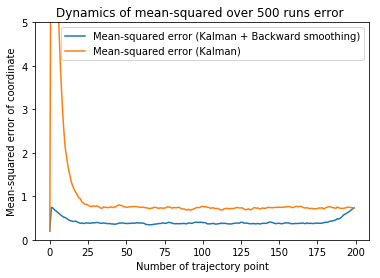

In [7]:
plt.plot(np.sqrt(Fin_Err_squared1), '-')
plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.title('Dynamics of mean-squared over 500 runs error ')
plt.ylabel('Mean-squared error of coordinate')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error (Kalman + Backward smoothing)', 'Mean-squared error (Kalman)'], loc = 'best')
plt.ylim((0,5))
plt.show()

We can see that the error of Kalman+Smoothing becomes approximately twice less and also we can see that the smoothing literally starts from the end (backward in the name), so this tells us that we're right in our code

All in all, we developed an algorithm to improve Kalman filter estimates, which is of prime importance for many practical control and forecasting problems. This brought about a deeper understanding of main difficulties of practical Kalman filter
implementation and skills to overcome these difficulties to get optimal assimilation output.